### `import` Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import imageio

from matplotlib import pyplot as plt
from sklearn.datasets import make_regression

### Data Preparation

In [2]:
X, y = make_regression(n_samples=200, n_features=1, noise=5, random_state=15)
df = pd.DataFrame(dict(col1=X[:, 0], col2=y))

In [3]:
df.shape

(200, 2)

### Train Test Split

In [4]:
def splitter(dframe, percentage=0.8, random_state=True):
    """
    :param DataFrame dframe: Pandas DataFrame
    :param float percentage: Percentage value to split the data
    :param boolean random_state: True/False
    :return: train_df, test_df
    """
    if random_state:
        dframe = dframe.sample(frac=1)

    thresh = round(len(dframe) * percentage)
    train_df = dframe.iloc[:thresh]
    test_df = dframe.iloc[thresh:]

    return train_df, test_df

In [5]:
train_df, test_df = splitter(dframe=df)

In [6]:
train_df.head()

,col1,col2
133,1.392231,9.552120
31,0.587376,1.645743
25,-0.782609,0.212952
170,0.192243,5.012631
197,-0.554025,-10.250867


In [7]:
test_df.head()

,col1,col2
29,-0.155909,-10.316879
36,1.289932,3.409999
194,-0.404502,-8.107950
81,-0.913569,-0.942559
158,0.235569,-4.045533


### Custom Linear Regression

In [8]:
class LinearRegression():
    def __init__(self, train_df, test_df, label, lambda_=0.001, n_iters=1000):
        self.n_iters = n_iters
        self.lambda_ = lambda_
        
        self.X_train, self.y_train = self.split_features_targets(df=train_df, label=label)
        self.X_test, self.y_test = self.split_features_targets(df=test_df, label=label)
        self.X_train = self.X_train.values
        self.y_train = self.y_train.values
        self.X_test = self.X_test.values
        self.y_test = self.y_test.values
        
        self.n_train = len(self.X_train)
        self.n_test = len(self.X_test)
        self.wb_params = {'w' : [], 'b' : []}
        self.w, self.b = self.find_best_params()
        
    def split_features_targets(self, df, label):
        X = df.drop(columns=[label], axis=1)
        y = df[label]
        return X, y
    
    def diff_params_wb(self, w, b):
        lm = np.dot(self.X_train, w) + b
        w_ = (2 / self.n_train) * np.dot(self.X_train.T, (lm - self.y_train))
        b_ = (2 / self.n_train) * np.sum((lm - self.y_train))
        return w_, b_
    
    def find_best_params(self):
        ow = np.zeros_like(a=self.X_train[0])
        ob = 0
        
        for i in range(self.n_iters):
            w_, b_ = self.diff_params_wb(w=ow, b=ob)
            ow = ow - (self.lambda_ * w_)
            ob = ob - (self.lambda_ * b_)
            self.wb_params['w'].append(ow)
            self.wb_params['b'].append(ob)
        
        return ow, ob
    
    def predict(self, with_plot=False, save_process=False):
        y_test_preds = np.dot(self.X_test, self.w) + self.b
        y_train_preds = np.dot(self.X_train, self.w) + self.b
        
        if with_plot:
            fig = plt.figure(figsize=(10, 4))

            ax1 = fig.add_subplot(1, 2, 1)
            ax1.title.set_text('Training')
            ax1.scatter(self.X_train, self.y_train, label='points')
            ax1.plot(self.X_train, y_train_preds, color='red', label='best fit')
            ax1.legend()
            
            ax2 = fig.add_subplot(1, 2, 2)
            ax2.title.set_text("Testing")
            ax2.scatter(self.X_test, self.y_test, label='points')
            ax2.plot(self.X_test, y_test_preds, color='red', label='best fit')
            ax2.legend()
            
            plt.show()
        
        if save_process:
            self.save_process_togif(test_x=self.X_test, test_y=self.y_test)
        
        return y_test_preds
    
    def save_process_togif(self, test_x, test_y):
        wp = self.wb_params['w']
        bp = self.wb_params['b']

        c = 0
        for i in range(0, len(wp), 50):
            c += 1
            d = '0' + str(c) if (len(str(c)) == 1) else str(c)
            test_p = np.dot(test_x, wp[i]) + bp[i]
        
            fig = plt.figure(figsize=(10, 10))
            plt.title("Testing")
            plt.scatter(test_x, test_y, label='points')
            plt.plot(test_x, test_p, color='red', label='best fit')
            plt.legend()
            plt.savefig('{}-lr-plot.png'.format(d))
            plt.close(fig)
        
        path = os.getcwd()
        files_list = os.listdir(path=path)
        png_list = [i for i in files_list if (i[0] != '.') and (i.split('.')[1] == 'png')]
        png_list.sort()
        png_gif = [imageio.imread(i) for i in png_list]
        kargs = {'duration': 1}
        gif_name = 'process-lin-reg.gif'
        imageio.mimsave(gif_name, png_gif, **kargs)
        print('Process saved in → ', path + '\\' + gif_name)
        
        return None
        
    def score(self, preds):
        preds = np.array(preds)
        
        if (len(self.y_test) == len(preds)):
            y_act_mean = np.mean(self.y_test)
            sst = np.sum((self.y_test - y_act_mean) ** 2)
            ssr = np.sum((self.y_test - preds) ** 2)
            return (1 - (ssr / sst))
        return "Lengths do not match"

### Testing

In [9]:
lr = LinearRegression(
    train_df=train_df, 
    test_df=test_df, 
    label='col2', 
    lambda_=0.01, 
    n_iters=1000
)

In [10]:
lr.w

array([6.19270391])

In [11]:
lr.b

-0.15889637257408215

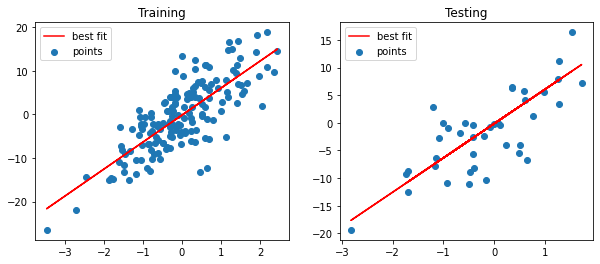

Process saved in →  C:\Users\tapal\OneDrive\Desktop\Sameer-Work\aaic_practice\Coding-ML\Linear-Reg-algo\process-lin-reg.gif


In [12]:
preds = lr.predict(with_plot=True, save_process=True)

In [13]:
lr.score(preds=preds)

0.5630871781610702

### End